In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import time
from scipy.stats import norm

from vax_sims_LHS_samples import *
from plot_utils import *
# from util_functions import *
# from uncertainty_analysis import *
# from sim_helper_functions import *

from fall_2021_projection_utils import aggregate_trajs_student_only

# Code to load and process simulation data 

In [2]:
base_folder = 'posterior_test_frequency_sims_1633821916/'

def get_fname_params(fname):
    fname_without_ext = fname.split('.dill')[0]
    fname_list = fname_without_ext.split('_')
    vax_rate = float(fname_list[2])
    L = int(fname_list[4])
    M = int(fname_list[6])
    N = int(fname_list[8])
    
    return vax_rate, L, M, N

sim_trajs = {}
sim_uncertainty_points = {}
sim_point_idxs = {}


count = 0

for fname in os.listdir(base_folder):
    with open(os.path.join(base_folder, fname), "rb") as fhandle:
        fname_params = get_fname_params(fname)
        posterior_point_idxs, posterior_points, inf_trajs_by_group = dill.load(fhandle)
        sim_trajs[fname_params] = inf_trajs_by_group
        sim_uncertainty_points[fname_params] = posterior_points
        sim_point_idxs[fname_params] = posterior_point_idxs
        
        count += 1

print("done loading {} simulation results".format(count))


done loading 120 simulation results


In [3]:
def compute_quantiles(sim_trajs, quantiles=[0.25, 0.5, 0.75], report_as_percentage=True):
    quantile_results = {q:{} for q in quantiles}
    for sim_type in sim_trajs:
        inf_matrix = np.array(sim_trajs[sim_type])
        final_student_infxns = np.sum(inf_matrix[:,:-2,-1], axis=1)
        quantile_results[sim_type] = []
        for q in quantiles:
            q_val = np.quantile(final_student_infxns, q)
            if report_as_percentage:
                quantile = q_val / 15072 * 100
            else:
                quantile = q_val
            quantile_results[q][sim_type] = quantile
    return quantile_results

quantile_results = compute_quantiles(sim_trajs, quantiles=[0.1, 0.5, 0.9])

# Code to estimate the total # of tests ran by each testing policy

In [5]:


from launch_fall_2021_posterior_sims_v3_contour import map_lhs_point_to_vax_sim

def get_group_sizes(vax_rate):
    vax_sim = map_lhs_point_to_vax_sim([1]*6, {}, [vax_rate] * 4)


    # order is [ug_ga_vax, ug_ga_unvax, ug_other_vax, ug_other_unvax, grad_vax, grad_unvax, ...]
    # corresponds to [0,   1,           2,             3,              4,          5,       ...]
    group_sim_idxs = {'ug_ga_vax': 0, 'ug_ga_unvax': 1, 'ug_other_vax': 2, 'ug_other_unvax': 3,
                     'grad_vax': 4, 'grad_unvax': 5}


    return {group: vax_sim.sims[group_sim_idx].pop_size 
                   for group, group_sim_idx in group_sim_idxs.items()}

vax_rate_group_sizes = {vax_rate:get_group_sizes(vax_rate) for vax_rate in [0.25, 0.5, 0.75, 1]}

In [6]:
for vax_rate in [0.25,0.5,0.75,1]:
    assert(sum(vax_rate_group_sizes[vax_rate].values()) == 15072 + 3101)

In [7]:


def get_test_policy(L,M,N):
    return {'ug_ga_vax': M/7, 'ug_ga_unvax': max(M,N)/7,
             'ug_other_vax': L/7, 'ug_other_unvax': N/7,
             'grad_vax': L/7, 'grad_unvax': N/7}




horizon_length = 112

testing_resources = {}

for sim_params in sim_trajs:
    vax_rate, L, M, N = sim_params
    test_policy = get_test_policy(L,M,N)
    group_sizes = vax_rate_group_sizes[vax_rate]
    daily_tests = 0
    for group, group_size in group_sizes.items():
        group_daily_tests = group_size * test_policy[group]
        daily_tests += group_daily_tests
    
    daily_tests_per_person = daily_tests / 15072
    
    testing_resources[sim_params] = daily_tests_per_person * 7
    

# Scatter plot of Pareto frontier for different vax rates

In [8]:
def get_non_dominated_params(vax_rate):
    sim_param_list = [(testing_resources[sim_params], quantile_results[0.5][sim_params], sim_params)
                     for sim_params in testing_resources if sim_params[0] == vax_rate]
    sorted_sim_info = sorted(sim_param_list, key=lambda x: x[0])
    smallest_infxns_so_far = 1e10
    tests_so_far = -1
    prev_tests_so_far = -1
    non_dominated_params = []

    for sim_info in sorted_sim_info:
        infxns = sim_info[1]
        prev_tests_so_far = tests_so_far
        tests_so_far = sim_info[0]
        if smallest_infxns_so_far <= infxns or prev_tests_so_far >= tests_so_far:
            continue
        else:
            smallest_infxns_so_far = infxns
            non_dominated_params.append(sim_info)

    return non_dominated_params

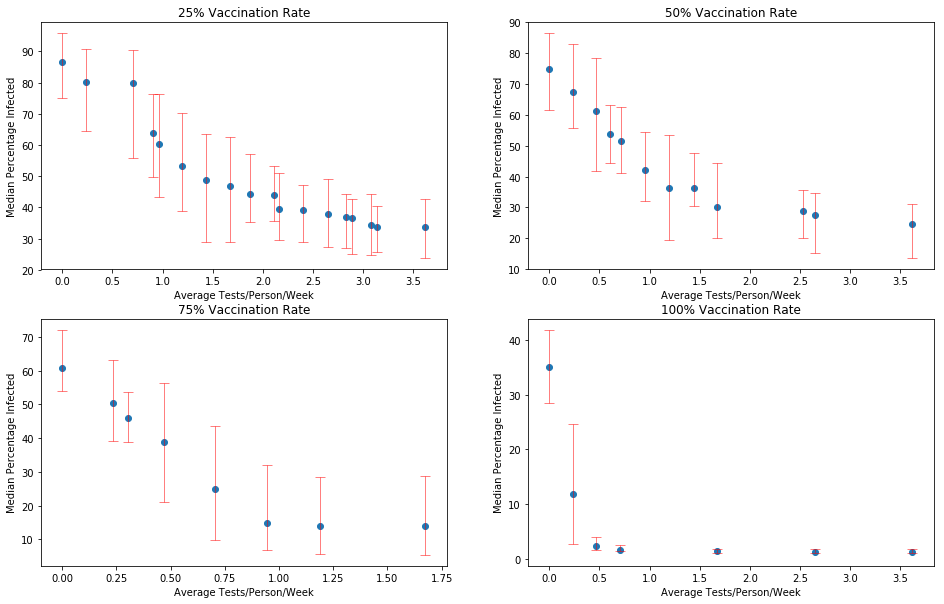

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

vax_rates = [0.25, 0.5, 0.75, 1]

plt.figure(figsize=(16,10))

for idx, vax_rate in enumerate(vax_rates):
    vax_rate_testing_resources = []
    median_final_infections = []
    errorbars = []
    
    non_dominated_params = get_non_dominated_params(vax_rate)
    
    for tests, infxns, sim_params in non_dominated_params:
        vax_rate_testing_resources.append(tests)
        median_final_infections.append(infxns)
        
        q10_infxns = quantile_results[0.1][sim_params]
        q90_infxns = quantile_results[0.9][sim_params]
        lower_err = infxns - q10_infxns
        upper_err = q90_infxns - infxns
        errorbars.append((lower_err, upper_err))
        
    
    plt.subplot(2,2,idx+1)
    plt.errorbar(vax_rate_testing_resources, median_final_infections, yerr = np.array(errorbars).T,
                fmt="none", capsize=5, ecolor='red', elinewidth=1, alpha=0.5)
    plt.scatter(vax_rate_testing_resources, median_final_infections)
    
    
    
    
    plt.xlabel("Average Tests/Person/Week")
    plt.ylabel("Median Percentage Infected")
    
    plt.title("{:n}% Vaccination Rate".format(vax_rate * 100))

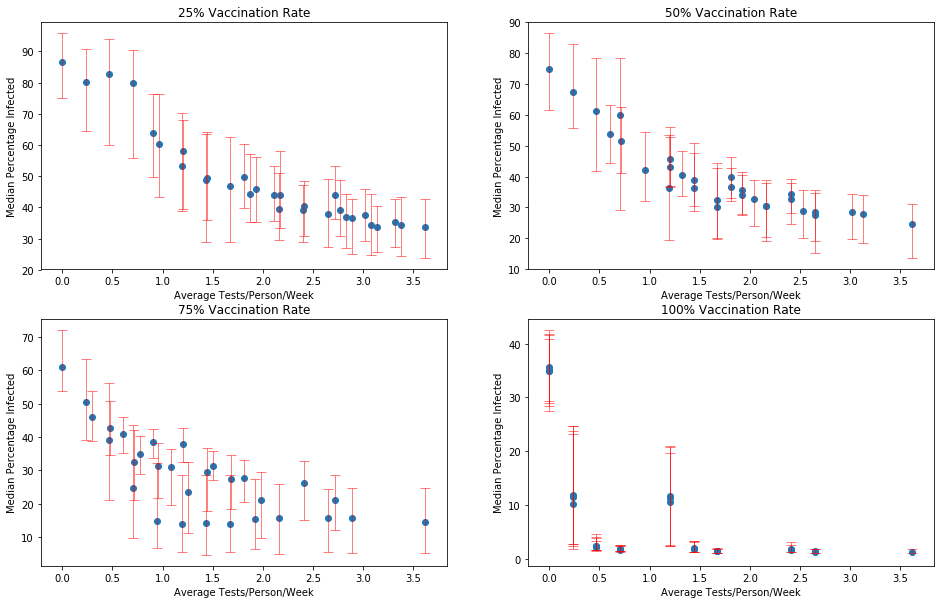

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

vax_rates = [0.25, 0.5, 0.75, 1]

plt.figure(figsize=(16,10))

for idx, vax_rate in enumerate(vax_rates):
    vax_rate_testing_resources = []
    median_final_infections = []
    errorbars = []
    
    non_dominated_params = [(testing_resources[sim_params], quantile_results[0.5][sim_params], sim_params)
                             for sim_params in testing_resources if sim_params[0] == vax_rate]
    
    for tests, infxns, sim_params in non_dominated_params:
        vax_rate_testing_resources.append(tests)
        median_final_infections.append(infxns)
        
        q10_infxns = quantile_results[0.1][sim_params]
        q90_infxns = quantile_results[0.9][sim_params]
        lower_err = infxns - q10_infxns
        upper_err = q90_infxns - infxns
        errorbars.append((lower_err, upper_err))
        
    
    plt.subplot(2,2,idx+1)
    plt.errorbar(vax_rate_testing_resources, median_final_infections, yerr = np.array(errorbars).T,
                fmt="none", capsize=5, ecolor='red', elinewidth=1, alpha=0.5)
    plt.scatter(vax_rate_testing_resources, median_final_infections)
    
    
    
    
    plt.xlabel("Average Tests/Person/Week")
    plt.ylabel("Median Percentage Infected")
    
    plt.title("{:n}% Vaccination Rate".format(vax_rate * 100))

# Make the combined version of the plot

Text(0.5,1,'Testing Resources vs. Infections')

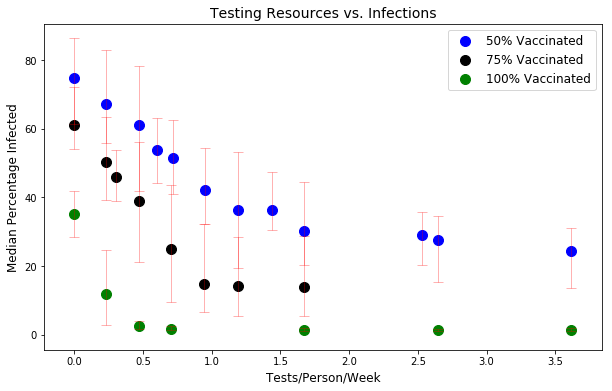

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

vax_rates = [0.5, 0.75, 1]

plt.figure(figsize=(10,6))

colours = ['blue', 'black', 'green']

for idx, vax_rate in enumerate(vax_rates):
    vax_rate_testing_resources = []
    median_final_infections = []
    errorbars = []
    
    non_dominated_params = get_non_dominated_params(vax_rate)
    
    for tests, infxns, sim_params in non_dominated_params:
        vax_rate_testing_resources.append(tests)
        median_final_infections.append(infxns)
        
        q10_infxns = quantile_results[0.1][sim_params]
        q90_infxns = quantile_results[0.9][sim_params]
        lower_err = infxns - q10_infxns
        upper_err = q90_infxns - infxns
        errorbars.append((lower_err, upper_err))
        
    
    #plt.subplot(2,2,idx+1)
    plt.errorbar(vax_rate_testing_resources, median_final_infections, yerr = np.array(errorbars).T,
                fmt="none", capsize=5, ecolor='red', elinewidth=1, alpha=0.3)
    plt.scatter(vax_rate_testing_resources, median_final_infections, color=colours[idx],
               label="{:n}% Vaccinated".format(vax_rate * 100), s=100)
    
    
    
    
plt.xlabel("Tests/Person/Week", fontsize=12)
plt.ylabel("Median Percentage Infected", fontsize=12)
plt.legend(fontsize=12)
plt.title("Testing Resources vs. Infections".format(vax_rate * 100), fontsize=14)